The U-Net model has dramatically improved overall medical image segmentation. However, for retinal vessel segmentation, U-Net-based architectures face the problem of difficult recognition of fine vessels and loss of feature information due to low image contrast. 


I have used the following methods.


* I used two image processing methods for images Green Channel Conversion, Histogram Equalization
* I used a morphological image processing method for masks Dilation
* Dice coefficient implementation,
* Custom layersfor encoding and decoding,
* Custom callback class  that used predicting a sample from the test dataset during training
* 1000 epochs for training (of course, although this number is very high, the metrics(dice, loss) continued improvement during training)


In [1]:
import warnings
warnings.filterwarnings('ignore')
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Layer, concatenate , BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

In [2]:
# Creating new folders---to save the output of preprocessed image

os.mkdir(os.path.join('/kaggle/working/', 'train_converted_images'))
os.mkdir(os.path.join('/kaggle/working/', 'train_converted_masks'))

os.mkdir(os.path.join('/kaggle/working/', 'test_converted_images'))
os.mkdir(os.path.join('/kaggle/working/', 'test_converted_masks'))

(-0.5, 511.5, 511.5, -0.5)

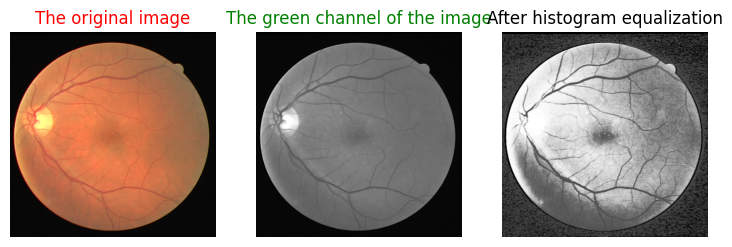

In [3]:
normal_image = cv2.imread('/kaggle/input/Data/train/image/0.png') 
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB) 
green_channnel = normal_image[:,::,1]

hist_eq_image = cv2.equalizeHist(green_channnel)

fig, axs = plt.subplots(1,3, figsize = (9,5), dpi = 100)

axs[0].imshow(normal_image)
axs[0].set_title('The original image', color = 'red')
axs[0].axis('off')

axs[1].imshow(green_channnel, cmap = 'gray')
axs[1].set_title('The green channel of the image', color ='green')
axs[1].axis('off')

axs[2].imshow(hist_eq_image, cmap = 'gray')
axs[2].set_title('After histogram equalization')
axs[2].axis('off')


In [4]:
def image_cvt_histeq(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :
        img = cv2.imread(os.path.join(main_path, i))[:,::,1] 
        img = cv2.equalizeHist(img)
        cv2.imwrite(os.path.join(target_path, i), img)

(-0.5, 511.5, 511.5, -0.5)

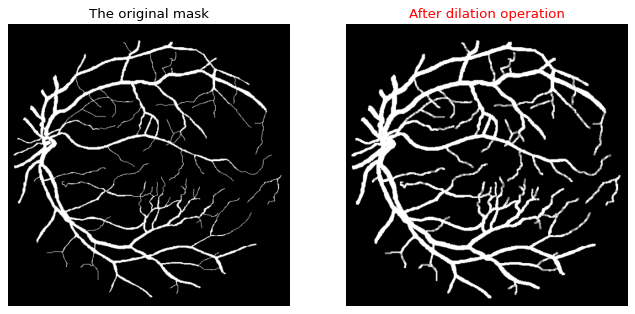

In [5]:
# mask dilation

normal_mask = cv2.imread('/kaggle/input/Data/train/mask/20.png')

kernel = np.ones((2,2))
dilated_mask = cv2.dilate(normal_mask, kernel, iterations = 2)

fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 80)

axs[0].imshow(normal_mask)
axs[0].set_title('The original mask')
axs[0].axis('off')

axs[1].imshow(dilated_mask, cmap = 'gray')
axs[1].set_title('After dilation operation', color ='red')
axs[1].axis('off')



In [6]:
# Mask dilation operation

def mask_dilation(main_path, target_path, morphological_kernel_size = 2 ):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :
        kernel = np.ones((morphological_kernel_size,morphological_kernel_size))
        
        mask = cv2.imread(os.path.join(main_path, i))
        mask = cv2.dilate(mask, kernel, iterations = 2)
        cv2.imwrite(os.path.join(target_path, i), mask)

In [7]:
# Applying image processing methods to all images and masks
image_cvt_histeq('/kaggle/input/Data/train/image', '/kaggle/working/train_converted_images')
mask_dilation('/kaggle/input/Data/train/mask','/kaggle/working/train_converted_masks' )

image_cvt_histeq('/kaggle/input/Data/test/image', '/kaggle/working/test_converted_images')
mask_dilation('/kaggle/input/Data/test/mask', '/kaggle/working/test_converted_masks')

In [8]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:

        full_path.append(os.path.join(path, i))
        
    return full_path


train_images = create_images_list('/kaggle/working/train_converted_images')
train_masks = create_images_list('/kaggle/working/train_converted_masks')


test_images = create_images_list('/kaggle/working/test_converted_images')
test_masks = create_images_list('/kaggle/working/test_converted_masks')


train_df = pd.DataFrame({'image' : train_images,'mask' : train_masks })
test_df = pd.DataFrame({'image' : test_images,'mask' : test_masks})

In [9]:
print("train images: ", train_df.shape[0])
print("test images: ", test_df.shape[0])

train images:  80
test images:  20


In [10]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.resize(img, size = (512, 512))
    img = tf.cast(img, tf.float32)/255.0
    
    mask = tf.io.read_file(label)
    mask = tf.io.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, size = (512, 512))
    mask = tf.cast(mask, tf.float32)/255.0
    
    return img, mask


def img_augmentation(image, label):
    img = tf.image.random_brightness(image, 0.2)
    img = tf.image.random_contrast(img, 0.2, 0.3)
    return img, label
    

In [11]:
# Creating dataset loaders
BATCH_SIZE = 8
train_loader = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['mask']))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .map(img_augmentation)
                 .batch(BATCH_SIZE)
                 .shuffle(train_df.shape[0])
                 .prefetch(BATCH_SIZE))


test_loader = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['mask']))
test_dataset = (test_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-9)
callbacks=[checkpoint, early_stop, reduce_lr]

In [24]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


## Updated UNet

In [38]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dropout, Input, Layer, concatenate, multiply, add
import tensorflow as tf
import numpy as np

def attention_block(filters, skip_connection, upsampled_connection, name='attention_block'):
    g = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer='he_normal')(skip_connection)
    x = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer='he_normal')(upsampled_connection)
    x = UpSampling2D(size=(2, 2))(x)

    combined = add([g, x])
    attention = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal', name=name)(combined)
    return multiply([skip_connection, attention])
class ASPPModule(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(ASPPModule, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        
        self.conv1x1_1 = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv3x3_1 = Conv2D(filters, 3, activation='relu', padding='same', dilation_rate=rate, kernel_initializer='he_normal')
        
        self.conv1x1_2 = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv3x3_2 = Conv2D(filters, 3, activation='relu', padding='same', dilation_rate=rate, kernel_initializer='he_normal')
        
        self.conv1x1_3 = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer='he_normal')
        self.conv3x3_3 = Conv2D(filters, 3, activation='relu', padding='same', dilation_rate=rate, kernel_initializer='he_normal')
        
        self.conv1x1_4 = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer='he_normal')

    def call(self, inputs):
        x1 = self.conv1x1_1(inputs)
        x2 = self.conv3x3_1(inputs)
        
        x3 = self.conv1x1_2(inputs)
        x3 = self.conv3x3_2(x3)
        
        x4 = self.conv1x1_3(inputs)
        x4 = self.conv3x3_3(x4)
        
        x5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputs)
        x5 = self.conv1x1_4(x5)
        
        return concatenate([x1, x2, x3, x4, x5])


class EncoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate
        self.pooling = pooling

        self.conv1 = Conv2D(filters, kernel_size, activation='relu', strides=1, padding='same', kernel_initializer='he_normal')
        self.conv2 = Conv2D(filters, kernel_size, activation='relu', strides=1, padding='same', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.pool = MaxPooling2D()

    def call(self, inputs):
        X = self.conv1(inputs)
        X = self.drop(X)
        X = self.conv2(X)
        if self.pooling:
            P = self.pool(X)
            return P, X
        else:
            return X

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "rate": self.rate,
            "pooling": self.pooling
        }


class DecoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate

        self.up = UpSampling2D()
        self.nn = EncoderBlock(filters, kernel_size, rate, pooling=False)

    def call(self, inputs):
        inputs, skip_inputs = inputs
        X = self.up(inputs)
        C = concatenate([X, skip_inputs])
        X = self.nn(C)
        return X

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "rate": self.rate,
        }


inp = Input(shape=(512, 512, 1))

p1, c1 = EncoderBlock(32, 2, 0.1, name='ENCODER_1')(inp)
p2, c2 = EncoderBlock(64, 2, 0.1, name='ENCODER_2')(p1)
p3, c3 = EncoderBlock(128, 2, 0.2, name='ENCODER_3')(p2)
p4, c4 = EncoderBlock(256, 2, 0.2, name='ENCODER_4')(p3)

# ASPP module
aspp_output = ASPPModule(256, 2, name='ASPP_MODULE')(p4)

# attention mechanism to the short connection
c4_attention = attention_block(256, c4, aspp_output, name='ATTENTION_4')
encoding = EncoderBlock(512, 2, 0.3, pooling=False, name='ENCODING')(aspp_output)

d1 = DecoderBlock(256, 2, 0.2, name='DECODER_1')([encoding, c4])
d2 = DecoderBlock(128, 2, 0.2, name='DECODER_2')([d1, c3])
d3 = DecoderBlock(64, 2, 0.1, name='DECODER_3')([d2, c2])
d4 = DecoderBlock(32, 2, 0.1, name='DECODER_4')([d3, c1])

out = Conv2D(1, 1, activation='sigmoid', padding='same')(d4)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef]) 

In [40]:
model.save("segmentation_model.keras")

In [41]:
hist = model.fit(train_dataset, batch_size= BATCH_SIZE,epochs = 1000 , callbacks = callbacks, verbose = 1)

Epoch 1/1000
10/10 [==============================] - 5s 464ms/step - loss: 0.5715 - dice_coef_loss: 0.8241 - dice_coef: 0.1759 - lr: 1.0000e-04
Epoch 2/1000
10/10 [==============================] - 5s 464ms/step - loss: 0.5094 - dice_coef_loss: 0.8318 - dice_coef: 0.1682 - lr: 1.0000e-04
Epoch 3/1000
10/10 [==============================] - 5s 463ms/step - loss: 0.4857 - dice_coef_loss: 0.8242 - dice_coef: 0.1758 - lr: 1.0000e-04
Epoch 4/1000
10/10 [==============================] - 5s 463ms/step - loss: 0.4659 - dice_coef_loss: 0.8173 - dice_coef: 0.1827 - lr: 1.0000e-04
Epoch 5/1000
10/10 [==============================] - 5s 463ms/step - loss: 0.4613 - dice_coef_loss: 0.8174 - dice_coef: 0.1826 - lr: 1.0000e-04
Epoch 6/1000
10/10 [==============================] - 5s 463ms/step - loss: 0.4530 - dice_coef_loss: 0.8116 - dice_coef: 0.1884 - lr: 1.0000e-04
Epoch 7/1000
10/10 [==============================] - 5s 463ms/step - loss: 0.4464 - dice_coef_loss: 0.8105 - dice_coef: 0.1895 - 

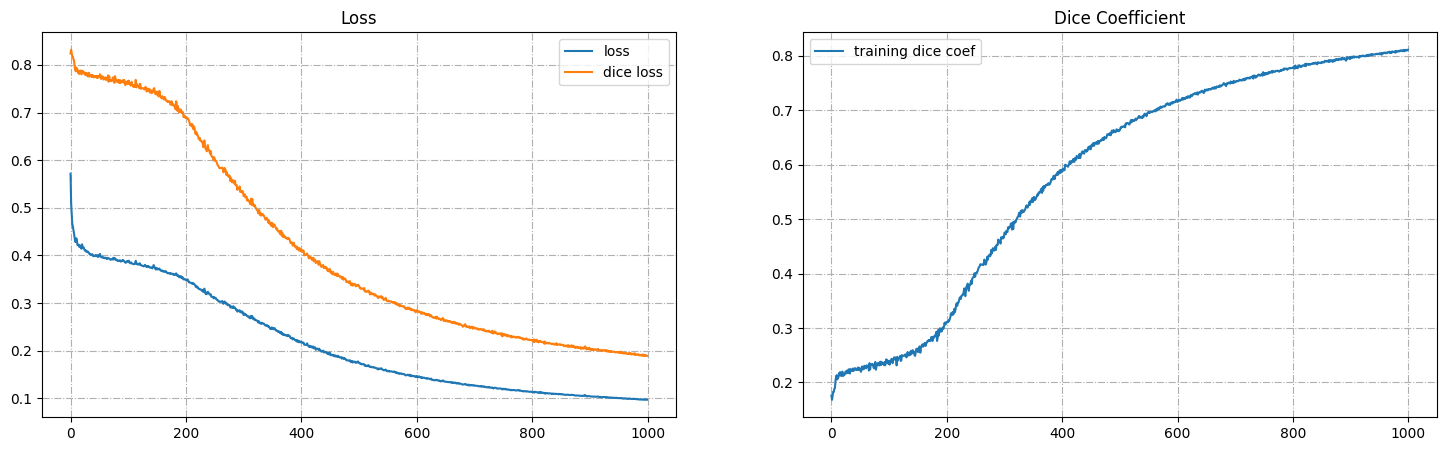

In [42]:
fig, axs = plt.subplots(1,2, figsize = (18,5), dpi = 100)
axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['dice_coef_loss'])
axs[0].legend(["loss", "dice loss"])
axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].legend(["training dice coef"])

In [43]:
train_eval = model.evaluate(train_dataset)

print('Train Dice Loss : {0:.4f}'.format(train_eval[1]))
print('Train Dice Coefficient : {0:.4f}'.format(train_eval[2]))

10/10 [==============================] - 2s 120ms/step - loss: 0.0792 - dice_coef_loss: 0.1738 - dice_coef: 0.8262
Train Dice Loss : 0.1738
Train Dice Coefficient : 0.8262


In [44]:
test_eval = model.evaluate(test_dataset)
print('Test Dice Loss : {0:.4f}'.format(test_eval[1]))
print('Test Dice Coefficient : {0:.4f}'.format(test_eval[2]))

3/3 [==============================] - 1s 501ms/step - loss: 0.4176 - dice_coef_loss: 0.3298 - dice_coef: 0.6702
Test Dice Loss : 0.3298
Test Dice Coefficient : 0.6702


In [45]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.75 
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.95
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)


3/3 [==============================] - 1s 122ms/step


In [46]:
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   

    fig, axs = plt.subplots(3,5, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        segmented = np.squeeze(test_take1_[batch_idx[i]][0][image_idx[i]] ) * pred_mask_1
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 5)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 5)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.75 threshold)', fontsize = 5)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.95 threshold)', fontsize = 5)
        
        axs[i][4].imshow(image , cmap ='gray')
        axs[i][4].imshow(segmented , alpha=0.5,  cmap = 'autumn')
        axs[i][4].axis('off')
        axs[i][4].set_title('segmentated vessel', fontsize = 5)

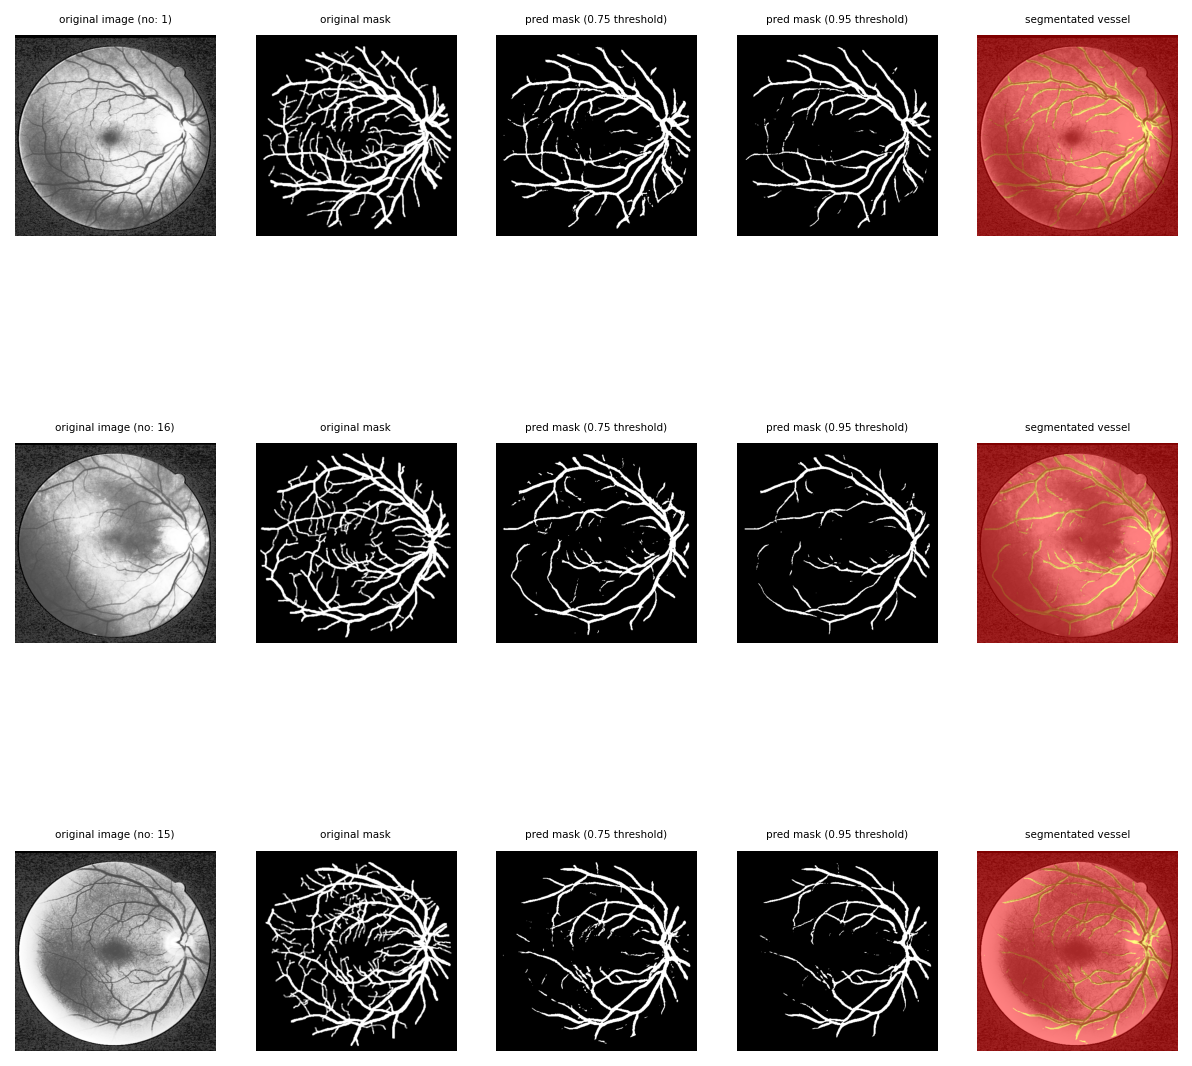

In [47]:
random_test_sample_with_prediction()

## UNet

In [48]:
class DecoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate
        
        self.up = UpSampling2D()
        self.nn = EncoderBlock(filters, kernel_size, rate, pooling = False)
    
    
    def call(self, inputs):
        inputs, skip_inputs = inputs
        X = self.up(inputs)
        C = concatenate([X, skip_inputs ])
        X = self.nn(C)
        return X
    
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "rate" : self.rate,
            "pooling" : self.pooling }
inp = Input(shape = (512, 512, 1))
p1,c1 = EncoderBlock(32, 2, 0.1, name = 'ENCODER_1')(inp)
p2,c2 = EncoderBlock(64, 2, 0.1, name =  'ENCODER_2')(p1)
p3,c3 = EncoderBlock(128, 2, 0.2, name =  'ENCODER_3')(p2)
p4,c4 = EncoderBlock(256, 2, 0.2,  name = 'ENCODER_4')(p3)

encoding = EncoderBlock(512 , 2, 0.3, pooling = False ,name = 'ENCODING')(p4)
 
d1 = DecoderBlock(256, 2, 0.2 ,name = 'DECODER_1' )([encoding, c4])
d2 = DecoderBlock(128 ,2, 0.2 ,name = 'DECODER_2' )([d1, c3])
d3 = DecoderBlock(64 ,2, 0.1 ,name = 'DECODER_3' )([d2, c2])
d4 = DecoderBlock(32 ,2, 0.1 ,name = 'DECODER_4' )([d3, c1])

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(d4)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef])       

In [49]:
hist = model.fit(train_dataset, batch_size= BATCH_SIZE,epochs = 1000 , callbacks = callbacks, verbose = 1)

Epoch 1/1000


2023-12-26 08:36:34.375819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/ENCODER_1/dropout_76/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


10/10 [==============================] - 11s 435ms/step - loss: 0.7775 - dice_coef_loss: 0.8199 - dice_coef: 0.1801 - lr: 0.0010
Epoch 2/1000
10/10 [==============================] - 5s 432ms/step - loss: 0.4669 - dice_coef_loss: 0.8301 - dice_coef: 0.1699 - lr: 0.0010
Epoch 3/1000
10/10 [==============================] - 5s 432ms/step - loss: 0.4557 - dice_coef_loss: 0.8271 - dice_coef: 0.1729 - lr: 0.0010
Epoch 4/1000
10/10 [==============================] - 5s 431ms/step - loss: 0.4480 - dice_coef_loss: 0.8165 - dice_coef: 0.1835 - lr: 0.0010
Epoch 5/1000
10/10 [==============================] - 5s 432ms/step - loss: 0.4441 - dice_coef_loss: 0.8244 - dice_coef: 0.1756 - lr: 0.0010
Epoch 6/1000
10/10 [==============================] - 5s 432ms/step - loss: 0.4477 - dice_coef_loss: 0.8135 - dice_coef: 0.1865 - lr: 0.0010
Epoch 7/1000
10/10 [==============================] - 5s 432ms/step - loss: 0.4408 - dice_coef_loss: 0.8198 - dice_coef: 0.1802 - lr: 0.0010
Epoch 8/1000
10/10 [=====

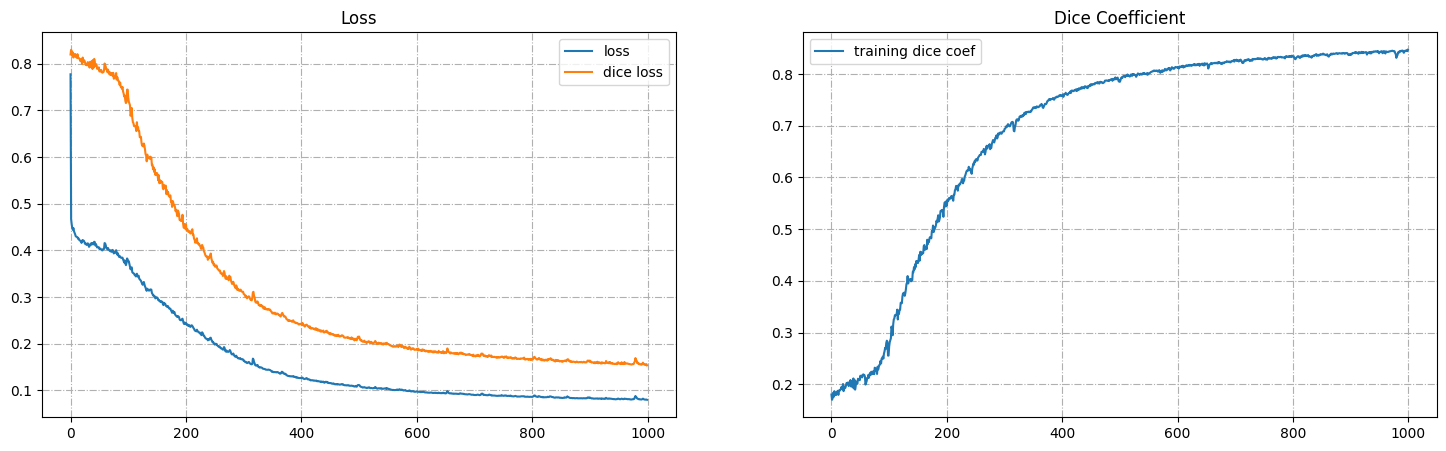

In [50]:
fig, axs = plt.subplots(1,2, figsize = (18,5), dpi = 100)
axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['dice_coef_loss'])
axs[0].legend(["loss", "dice loss"])
axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].legend(["training dice coef"])

In [51]:
train_eval = model.evaluate(train_dataset)

print('Train Dice Loss : {0:.4f}'.format(train_eval[1]))
print('Train Dice Coefficient : {0:.4f}'.format(train_eval[2]))

10/10 [==============================] - 2s 109ms/step - loss: 0.0652 - dice_coef_loss: 0.1333 - dice_coef: 0.8667
Train Dice Loss : 0.1333
Train Dice Coefficient : 0.8667


In [52]:
test_eval = model.evaluate(test_dataset)
print('Test Dice Loss : {0:.4f}'.format(test_eval[1]))
print('Test Dice Coefficient : {0:.4f}'.format(test_eval[2]))

3/3 [==============================] - 0s 102ms/step - loss: 0.4495 - dice_coef_loss: 0.3341 - dice_coef: 0.6659
Test Dice Loss : 0.3341
Test Dice Coefficient : 0.6659


In [53]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.75 
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.95
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)


3/3 [==============================] - 0s 104ms/step


In [54]:
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   

    fig, axs = plt.subplots(3,5, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        segmented = np.squeeze(test_take1_[batch_idx[i]][0][image_idx[i]] ) * pred_mask_1
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 5)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 5)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.75 threshold)', fontsize = 5)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.95 threshold)', fontsize = 5)
        
        axs[i][4].imshow(image , cmap ='gray')
        axs[i][4].imshow(segmented , alpha=0.5,  cmap = 'autumn')
        axs[i][4].axis('off')
        axs[i][4].set_title('segmentated vessel', fontsize = 5)

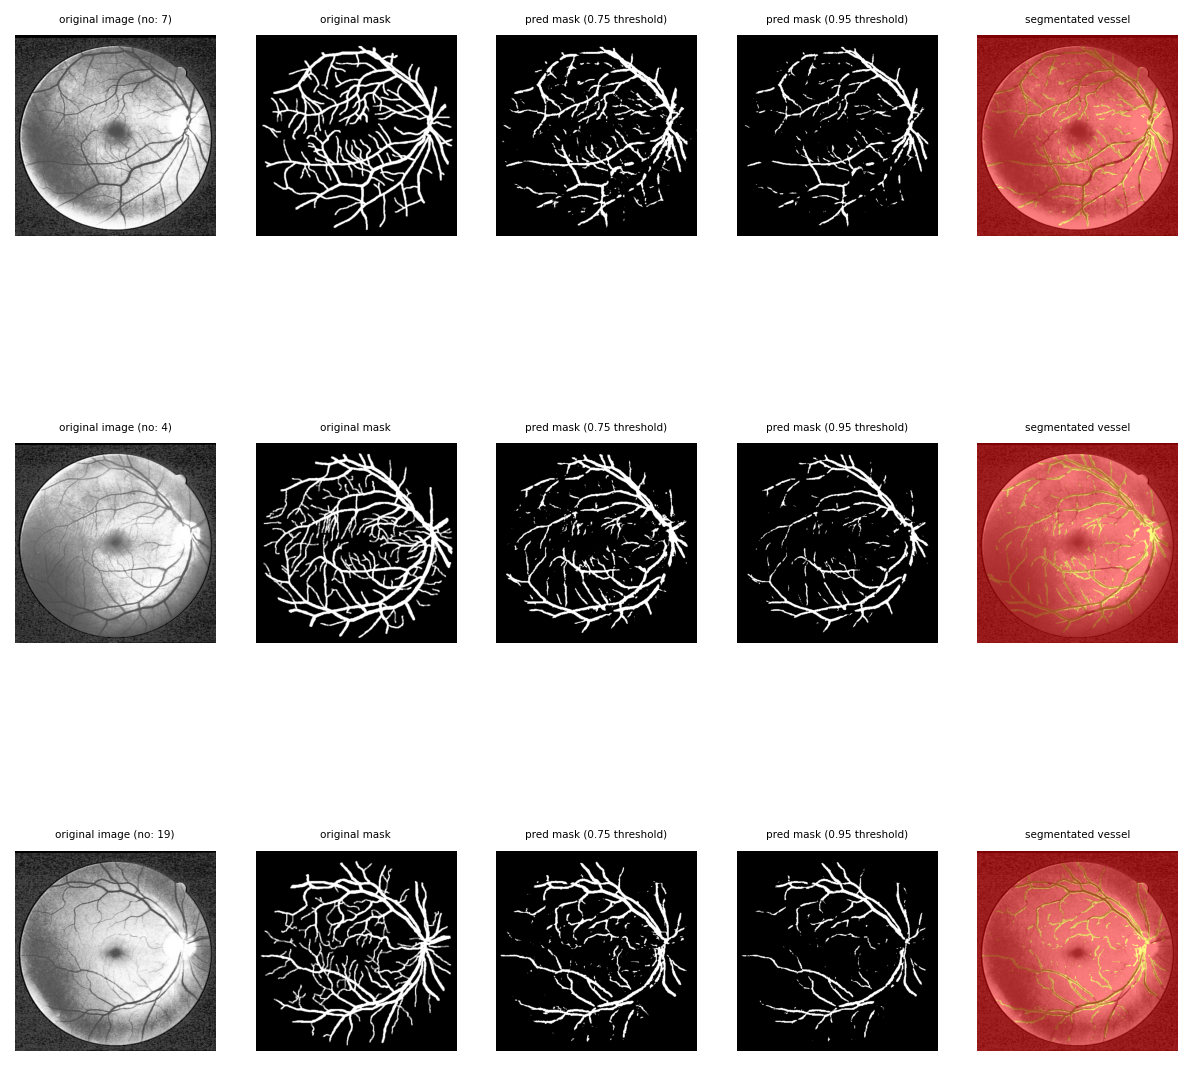

In [55]:
random_test_sample_with_prediction()